# spikeinterface template matching

Template matching is the final step used in many tools (kilosort, spyking-circus, yass, tridesclous, hdsort...)

In this step, from a given catalogue (aka dictionnary) of template (aka atoms), algorithms explain traces as 
a linear sum of template plus residual noise.

We have started to implement some template matching procedure in spikeinterface.

Here a small demo and also some benchmark to compare performance of theses algos.


For this we will use a simulated with **mearec** dataset on 32 channel neuronexus like probe.
Then we will compute the true template using the true sorting.
Theses true templates will be used for diffrents method.
And then we will apply comparison to ground truth procedure to estimate only this step.




In [2]:
# %matplotlib widget
%matplotlib inline

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from pathlib import Path

import time

import numpy as np
import matplotlib.pyplot as plt


import spikeinterface.full as si



In [18]:

base_folder = Path('/mnt/data/sam/DataSpikeSorting/mearec_template_matching')
mearec_file = base_folder / 'recordings_collision_15cells_Neuronexus-32_1800s.h5'
wf_folder = base_folder / 'Waveforms_recording_15cells_Neuronexus-32_1800s'
rec_folder = base_folder /'Preprocessed_recording_15cells_Neuronexus-32_1800s'


### open and preprocess

In [19]:

# load already cache or compute
if rec_folder.exists():
    recording = si.load_extractor(rec_folder)
else:
    recording, gt_sorting = si.read_mearec(mearec_file)
    recording = si.bandpass_filter(recording, dtype='float32')
    recording = si.common_reference(recording)
    recording = recording.save(folder=rec_folder, n_jobs=20, chunk_size=30000, progress_bar=True)

write_binary_recording with n_jobs 20  chunk_size 30000


write_binary_recording: 100%|██████████| 1800/1800 [00:16<00:00, 106.25it/s]


### construct true templates

In [20]:
_, gt_sorting = si.read_mearec(mearec_file)
recording = si.load_extractor(rec_folder)

In [21]:
we = si.extract_waveforms(recording, gt_sorting, wf_folder, load_if_exists=True,
                           ms_before=2.5, ms_after=3.5, max_spikes_per_unit=500,
                           n_jobs=20, chunk_size=30000, progress_bar=True)
print(we)

extract waveforms memmap: 100%|██████████| 1800/1800 [00:11<00:00, 151.50it/s]


WaveformExtractor: 32 channels - 15 units - 1 segments
  before:75 after:105 n_per_units:500


In [23]:
metrics = si.compute_quality_metrics(we, metric_names=['snr'], load_if_exists=True)
metrics

,snr
#0,42.573563
#1,23.475538
#2,11.677200
#3,8.544864
#4,61.134109
#5,49.281887
#6,31.793837
#7,36.275745
#8,12.932632
#9,39.769772


### run several method of template matching

A unique function is used for that `find_spikes_from_templates()`

In [28]:
from spikeinterface.sortingcomponents.template_matching import find_spikes_from_templates

In [25]:
# Some method need teh noise level (for internal detection)
noise_levels = si.get_noise_levels(recording, return_scaled=False)
noise_levels

array([3.9969404, 3.9896376, 3.8046541, 3.5555122, 3.3091464, 3.257736 ,
       3.6201818, 3.9503036, 4.079712 , 4.2103205, 3.8557687, 3.9278026,
       3.8464408, 3.651188 , 3.4105062, 3.2170172, 3.3981993, 3.7377162,
       3.9932737, 4.1710896, 4.2710056, 4.296086 , 3.7716963, 3.7748668,
       3.6391177, 3.4687228, 3.3020885, 3.3594728, 3.6073673, 3.8444421,
       4.0852304, 4.234068 ], dtype=float32)

In [29]:
## this method support parallel computing
job_kwargs = dict(
    n_jobs=40,
    chunk_size=30000,
    progress_bar=True
)

In [30]:
# lets build dict for handling parameters
methods = {}
methods['naive'] =  ('naive', 
                    {'waveform_extractor' : we})
methods['tridesclous'] =  ('tridesclous',
                           {'waveform_extractor' : we,
                            'noise_levels' : noise_levels,
                            'num_closest' :3})
methods['circus'] =  ('circus',
                      {'waveform_extractor' : we,
                       'noise_levels' : noise_levels})
methods['circus-omp'] =  ('circus-omp',
                          {'waveform_extractor' : we,
                           'noise_levels' : noise_levels})


spikes_by_methods = {}
for name,  (method, method_kwargs) in methods.items():
    spikes = find_spikes_from_templates(recording, method=method, method_kwargs=method_kwargs, **job_kwargs)
    spikes_by_methods[name] = spikes

find spikes (circus-omp): 100%|██████████| 1800/1800 [00:28<00:00, 62.85it/s]


In [34]:
## the output of every method is a numpy array with a complex dtype

spikes = spikes_by_methods['tridesclous']
print(spikes.dtype)
print(spikes.shape)
print(spikes[:5])



[('sample_ind', '<i8'), ('channel_ind', '<i8'), ('cluster_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')]
(234977,)
[( 59,  0,  4, 1., 0) (309, 21,  8, 1., 0) (371, 13,  3, 1., 0)
 (623, 30, 14, 1., 0) (713, 31, 13, 1., 0)]


### check performances method by method

For this:
  1. we transform the `spikes` vector into a `sorting` object
  2. use the `compare_sorter_to_ground_truth()` function to compute performances
  3. plot agreement matrix
  4. plot accuracy vs snr
  5. plot collision vs similarity


Note:
 * as we provide the true template list every matrix is supposed to be squared!!!
   The performances are can be seen on the diagonal. A perfect matching is supposed to have only ones on the diagonal.
 * The dataset here is one the dataset used in  [collision paper](https://www.biorxiv.org/content/10.1101/2021.11.29.470450v1)
   We can also make a fine benchmark on inspecting collision.



In [33]:
# load metrics for snr on true template
metrics = we.load_extension('quality_metrics').get_metrics()



NumpySorting: 15 units - 1 segments - 30.0kHz
NumpySorting: 15 units - 1 segments - 30.0kHz
NumpySorting: 15 units - 1 segments - 30.0kHz
NumpySorting: 15 units - 1 segments - 30.0kHz


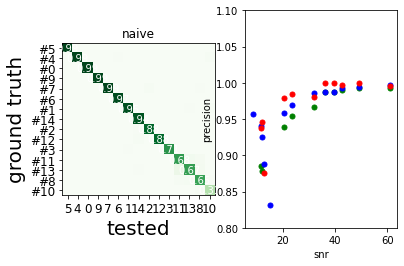

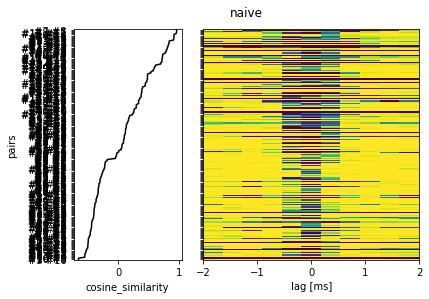

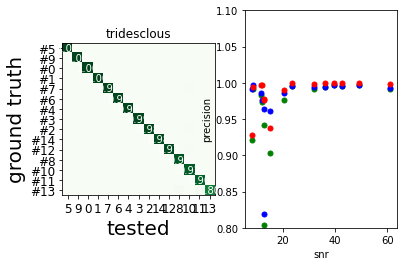

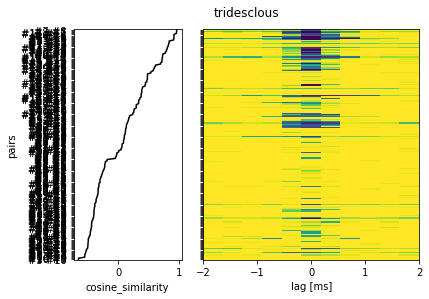

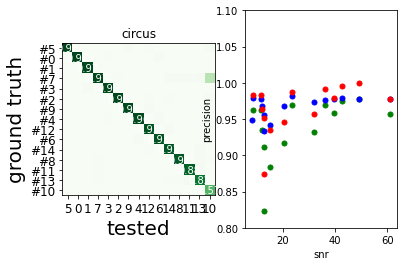

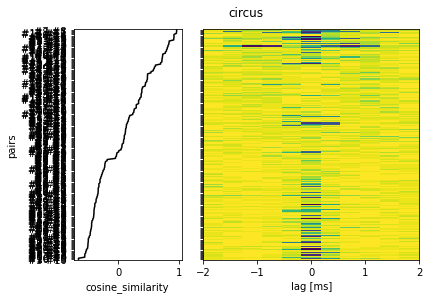

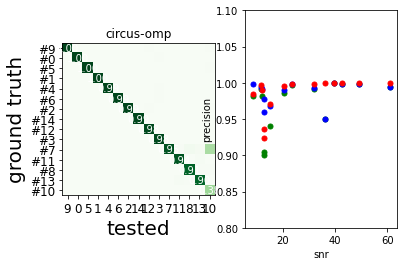

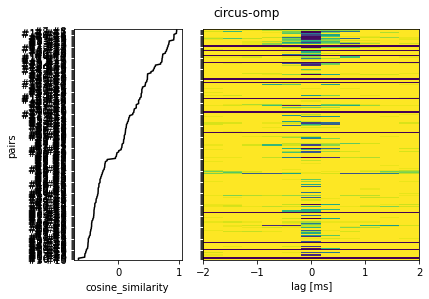

In [35]:
templates = we.get_all_templates()

comparisons = {}
for name,  (method, method_kwargs) in methods.items():
    spikes = spikes_by_methods[name]

    sorting = si.NumpySorting.from_times_labels(spikes['sample_ind'], spikes['cluster_ind'], recording.get_sampling_frequency())
    print(sorting)

    comp = si.compare_sorter_to_ground_truth(gt_sorting, sorting)
    

    fig, axs = plt.subplots(ncols=2)
    si.plot_agreement_matrix(comp, ax=axs[0])
    si.plot_sorting_performance(comp, metrics, performance_name='accuracy', metric_name='snr', ax=axs[1], color='g')
    si.plot_sorting_performance(comp, metrics, performance_name='recall', metric_name='snr', ax=axs[1], color='b')
    si.plot_sorting_performance(comp, metrics, performance_name='precision', metric_name='snr', ax=axs[1], color='r')
    axs[0].set_title(name)
    axs[1].set_ylim(0.8, 1.1)
    
    comp = si.CollisionGTComparison(gt_sorting, sorting)
    comparisons[name] = comp
    fig, ax = plt.subplots()
    si.plot_comparison_collision_by_similarity(comp, templates, figure=fig)
    fig.suptitle(name)

plt.show()

### comparison of methods 2 by 2

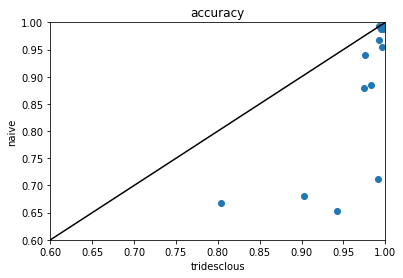

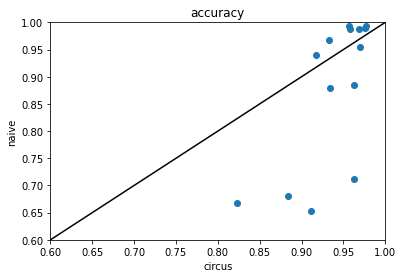

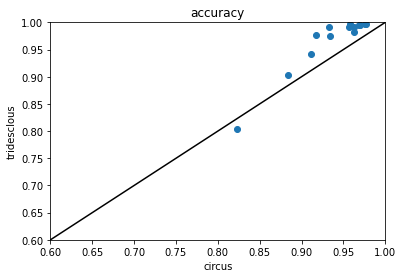

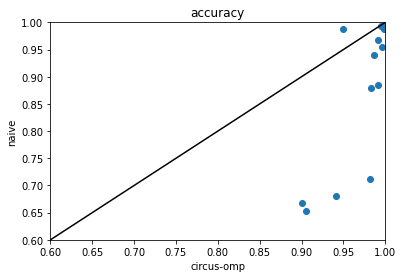

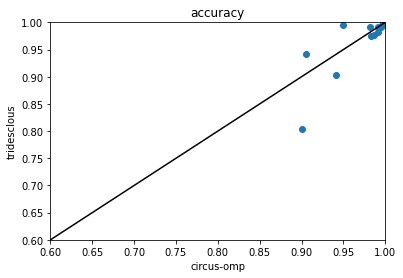

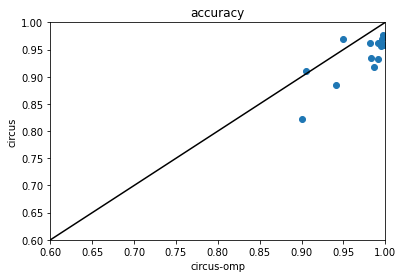

In [36]:
names = list(comparisons.keys())
n = len(names)

for r, name0 in enumerate(names):
    for c, name1 in enumerate(names):
        if r<=c:
            continue

        fig, ax = plt.subplots()
        val0 = comparisons[name0].get_performance()['accuracy']
        val1 = comparisons[name1].get_performance()['accuracy']
        ax.scatter(val0, val1)
        ax.set_xlabel(name0)
        ax.set_ylabel(name1)
        ax.plot([0,1], [0, 1], color='k')
        ax.set_title('accuracy')
        ax.set_xlim(0.6, 1)
        ax.set_ylim(0.6, 1)


### conclusion

* **tridesclous** and **circus-omp** are clear winner for performances
* **tridesclous** is the fastest
* Improvement must be done because performances are far to be perfect!!!
